In [ ]:
! pip install --upgrade kapre

Code from https://www.tensorflow.org/tutorials/audio/simple_audio    
TPU Example https://www.kaggle.com/mgornergoogle/five-flowers-with-keras-and-xception-on-tpu#TPU-or-GPU-detection  
Log Mel Spectrogram: https://towardsdatascience.com/how-to-easily-process-audio-on-your-gpu-with-tensorflow-2d9d91360f06

In [ ]:
import os
import pathlib

import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import kapre
from kapre import STFT, Magnitude, MagnitudeToDecibel, Delta, Frame
from kapre.composed import get_melspectrogram_layer, get_log_frequency_spectrogram_layer, get_stft_magnitude_layer

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Tensorflow version 2.4.1


In [ ]:
try: # detect TPUs
    # NEW: in Tensorflow 2.4
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # otherwise detect GPUs
    strategy = tf.distribute.MirroredStrategy() # single-GPU or multi-GPU


print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.80.243.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.80.243.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'colab-tpu-310620'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
# path = '../Data'
# path = '/scratch/na5zn/Audio-Language-Detection/Data/segments'
# path = '/content/drive/MyDrive/Repositories/Audio-Language-Detection/Data/segments'
path = 'gs://sys6018_audio/segments'

In [ ]:
languages = np.array(tf.io.gfile.listdir(path))
languages = list(map(lambda x: x.replace('/', ''), languages))
print('Languages:', languages)

num_labels = len(languages)

Languages: ['en', 'it']


In [ ]:
def get_file_lists(tfr_dir):

  #list all files with training data
  # train_shards = glob.glob(tfr_dir+"*_train.tfrecords", recursive=False)
  train_shards = list(!gsutil ls -r gs://sys6018_audio/tfrecords/train-*.tfrec)
  sorted(train_shards) #for same same input order over all runs 

  #list all files with test data
  # test_shards = glob.glob(tfr_dir+"*_test.tfrecords", recursive=False)
  test_shards = list(!gsutil ls -r gs://sys6018_audio/tfrecords/test-*.tfrec)
  sorted(test_shards) #for same same input order over all runs 

  #list all files with validation data
  # valid_shards = glob.glob(tfr_dir+"*_valid.tfrecords", recursive=False)
  valid_shards = list(!gsutil ls -r gs://sys6018_audio/tfrecords/validate-*.tfrec)
  sorted(valid_shards) #for same same input order over all runs 

  logger1.info(f"Number of training, test, and validation shards: {len(train_shards), len(test_shards), len(valid_shards)}")

  return train_shards, test_shards, valid_shards

def parse_tfr_elem(element):
  '''
   extract the features from a TFrecord element
  '''
  
  parse_dict = {
      'x': tf.io.FixedLenFeature([], tf.int64),
      'y':tf.io.FixedLenFeature([], tf.int64),
      'label':tf.io.FixedLenFeature([], tf.int64),
      'feature' : tf.io.FixedLenFeature([], tf.string)}

  example_message = tf.io.parse_single_example(element, parse_dict)

  x = example_message['x']
  y = example_message['y']
  feature = example_message['feature']
  label = example_message['label']

  feature = tf.io.parse_tensor(feature, out_type=tf.float32)
  feature = tf.reshape(feature, shape=[x,y])

  return (feature, label)

def load_dataset(tfrecords, cache_path=None, batch_size=8, seed=1337):
  
  AUTOTUNE = tf.data.experimental.AUTOTUNE #automatic optimizer for caching, prefetching (later on)
  
  options = tf.data.Options()
  options.experimental_deterministic = False #speed up file processing by not waiting for files to be in order

  dataset = tf.data.TFRecordDataset(tfrecords, buffer_size=100000000)
  dataset.with_options(options)

  dataset = dataset.map(map_func=parse_tfr_elem, num_parallel_calls=AUTOTUNE)
  dataset = dataset.prefetch(AUTOTUNE)
  if cache_path is not None:
    dataset = dataset.cache(cache_path)
  else:
    dataset = dataset.cache() #hold cache in RAM

  dataset = dataset.shuffle(10, seed=seed, reshuffle_each_iteration=True)
  dataset = dataset.batch(batch_size=batch_size)
  dataset = dataset.repeat() #always repeat to run multiple epochs and multiple test/val runs

  return dataset

In [ ]:
  #first load the shards, then create a dataset object from them
  train_shards, test_shards, valid_shards = get_file_lists(tfr_dir=args['tfr_dir'])
  train_dataset = load_dataset(tfrecords=train_shards, cache_path=None, batch_size=batch_size, seed=args['seed'])
  validation_dataset = load_dataset(tfrecords=valid_shards, cache_path=None, batch_size=batch_size, seed=args['seed'])
  test_dataset = load_dataset(tfrecords=test_shards, cache_path=None, batch_size=batch_size, seed=args['seed'])

In [ ]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
TRAIN_STEPS = train_files.shape[0] // BATCH_SIZE
VALIDATION_STEPS = -(-val_files.shape[0] // BATCH_SIZE)

Learning rate schedule: 1e-05 to 0.0004 to 2.72e-05


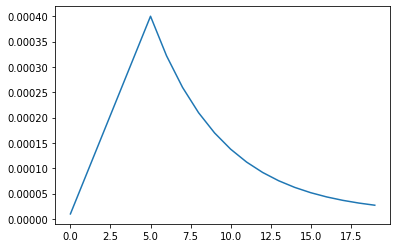

In [ ]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

EPOCHS = 20

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
keras.backend.clear_session()

sampling_rate = 22050  # sampling rate of your input audio
duration = 3.0  # duration of the audio
num_channel = 1  # number of channels of the audio
input_shape = (int(sampling_rate * duration), num_channel)  # let's follow `channels_last` convention

with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  # norm_layer = preprocessing.Normalization()
  # norm_layer.adapt(unbatched_train_ds.map(lambda x, _: x))

  model = models.Sequential([
      layers.Input(shape=input_shape),
      # get_stft_magnitude_layer(input_shape=input_shape, return_decibel=True),
      get_melspectrogram_layer(n_mels=config['n_mels'], sample_rate=22050, win_length=config['win_length'], n_fft=config['n_fft'], return_decibel=True, output_data_format='channels_last')

      # preprocessing.Resizing(32, 32), 
      # norm_layer,
      layers.Conv2D(32, 16, activation='relu'),
      layers.MaxPooling2D(),
      # layers.Dropout(0.25),
      layers.Flatten(),
      # layers.Dense(128, activation='relu'),
      # layers.Dropout(0.5),
      layers.Dense(num_labels, activation='softmax'),
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 114, 32)      8224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 57, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 456000)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 912002    
Total params: 920,226
Trainable params: 920,226
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
  steps_per_execution=8
)

In [ ]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS, 
    validation_steps=VALIDATION_STEPS,
    # callbacks=[lr_callback, tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)]
)

Epoch 1/20
325/325 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.7365 WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 70 batches). You may need to use the repeat() function when building your dataset.


OutOfRangeError: ignored

In [ ]:
save_path = '/content/drive/MyDrive/Repositories/Audio-Language-Detection/models/model1'
model.save(save_path, options=save_locally)

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=languages, yticklabels=languages, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()